In [ ]:
using Pkg
Pkg.activate(@__DIR__)

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV

### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [10]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.883495,0.834987,0.026826,0.114536,2.0,1.0,2.0,3.0
2,0.925139,0.697656,0.350818,0.123783,1.0,2.0,1.0,1.0
3,0.087816,0.718123,0.519254,0.445656,2.0,4.0,1.0,1.0
4,0.185981,0.143434,0.282807,0.616809,1.0,1.0,2.0,2.0
5,0.529795,0.769316,0.732921,0.697112,3.0,2.0,2.0,4.0
6,0.931836,0.845873,0.242734,0.5763,1.0,1.0,2.0,1.0
7,0.19921,0.981126,0.172411,0.796912,3.0,3.0,1.0,3.0
8,0.830111,0.202595,0.357459,0.0735882,3.0,1.0,2.0,2.0
9,0.353203,0.150121,0.812328,0.706758,1.0,3.0,1.0,1.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `SMOTE-NC` assumes that all categorical features have `sci-type` finite.

In [11]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,0.883495,0.834987,0.026826,0.114536,2.0,1.0,2.0,3.0
2,0.925139,0.697656,0.350818,0.123783,1.0,2.0,1.0,1.0
3,0.087816,0.718123,0.519254,0.445656,2.0,4.0,1.0,1.0
4,0.185981,0.143434,0.282807,0.616809,1.0,1.0,2.0,2.0
5,0.529795,0.769316,0.732921,0.697112,3.0,2.0,2.0,4.0
6,0.931836,0.845873,0.242734,0.5763,1.0,1.0,2.0,1.0
7,0.19921,0.981126,0.172411,0.796912,3.0,3.0,1.0,3.0
8,0.830111,0.202595,0.357459,0.0735882,3.0,1.0,2.0,2.0
9,0.353203,0.150121,0.812328,0.706758,1.0,3.0,1.0,1.0


### 2. Apply SMOTE-NC

#### Using Imbalance Only

Applying SMOTE-NC using the standard API is very straightforward. There are two main hyperparameters which are the number of nearest neighbors `k` and the wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [12]:
Xover, yover = smotenc(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

(141×8 DataFrame
 Row │ Column1    Column2    Column3   Column4    Column5  Column6  Column7  C ⋯
     │ Float64    Float64    Float64   Float64    Cat…     Cat…     Cat…     C ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.883495   0.834987   0.026826  0.114536   2.0      1.0      2.0      3 ⋯
   2 │ 0.925139   0.697656   0.350818  0.123783   1.0      2.0      1.0      1
   3 │ 0.087816   0.718123   0.519254  0.445656   2.0      4.0      1.0      1
   4 │ 0.185981   0.143434   0.282807  0.616809   1.0      1.0      2.0      2
   5 │ 0.529795   0.769316   0.732921  0.697112   3.0      2.0      2.0      4 ⋯
   6 │ 0.931836   0.845873   0.242734  0.5763     1.0      1.0      2.0      1
   7 │ 0.19921    0.981126   0.172411  0.796912   3.0      3.0      1.0      3
   8 │ 0.830111   0.202595   0.357459  0.0735882  3.0      1.0      2.0      2
  ⋮  │     ⋮          ⋮         ⋮          ⋮         ⋮        ⋮        ⋮       ⋱
 135 │ 0.554572   0.876

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [13]:
smotenc_model = Imbalance.MLJ.SMOTENC(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)

(141×8 DataFrame
 Row │ Column1    Column2    Column3   Column4    Column5  Column6  Column7  C ⋯
     │ Float64    Float64    Float64   Float64    Cat…     Cat…     Cat…     C ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.883495   0.834987   0.026826  0.114536   2.0      1.0      2.0      3 ⋯
   2 │ 0.925139   0.697656   0.350818  0.123783   1.0      2.0      1.0      1
   3 │ 0.087816   0.718123   0.519254  0.445656   2.0      4.0      1.0      1
   4 │ 0.185981   0.143434   0.282807  0.616809   1.0      1.0      2.0      2
   5 │ 0.529795   0.769316   0.732921  0.697112   3.0      2.0      2.0      4 ⋯
   6 │ 0.931836   0.845873   0.242734  0.5763     1.0      1.0      2.0      1
   7 │ 0.19921    0.981126   0.172411  0.796912   3.0      3.0      1.0      3
   8 │ 0.830111   0.202595   0.357459  0.0735882  3.0      1.0      2.0      2
  ⋮  │     ⋮          ⋮         ⋮          ⋮         ⋮        ⋮        ⋮       ⋱
 135 │ 0.554572   0.876

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `smotenc` will take of encoding them and decoding them before and after applying the actual algorithm.

In [14]:
# For TableTransforms
Xy = CSV.read("../datasets/churn.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,Cat…,Int64,Cat…,Cat…,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0
6,6,15574012,Chu,645,Spain,Male,44,8,1.13756e5,2,1,0,1.49757e5,1
7,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.8,0
8,8,15656148,Obinna,376,Germany,Female,29,4,1.15047e5,4,1,0,1.19347e5,1
9,9,15792365,He,501,France,Male,44,4,1.42051e5,2,0,1,74940.5,0


Now we instantiate the model and simply pass the data to it using the pipeline operator `\>`. This is equivalent to calling `apply` from table transforms.

In [15]:
using Imbalance: TableTransforms.SMOTENC
y_ind = 14
smote_model_t = SMOTENC(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


In [16]:
smote_model_t = SMOTENC(5, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:15



Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
  class:  2.0


Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


### 3. Plot the Results

We can finally plot the data before and after to validate the results.

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/simple_examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/simple_examples/Manifest.toml`


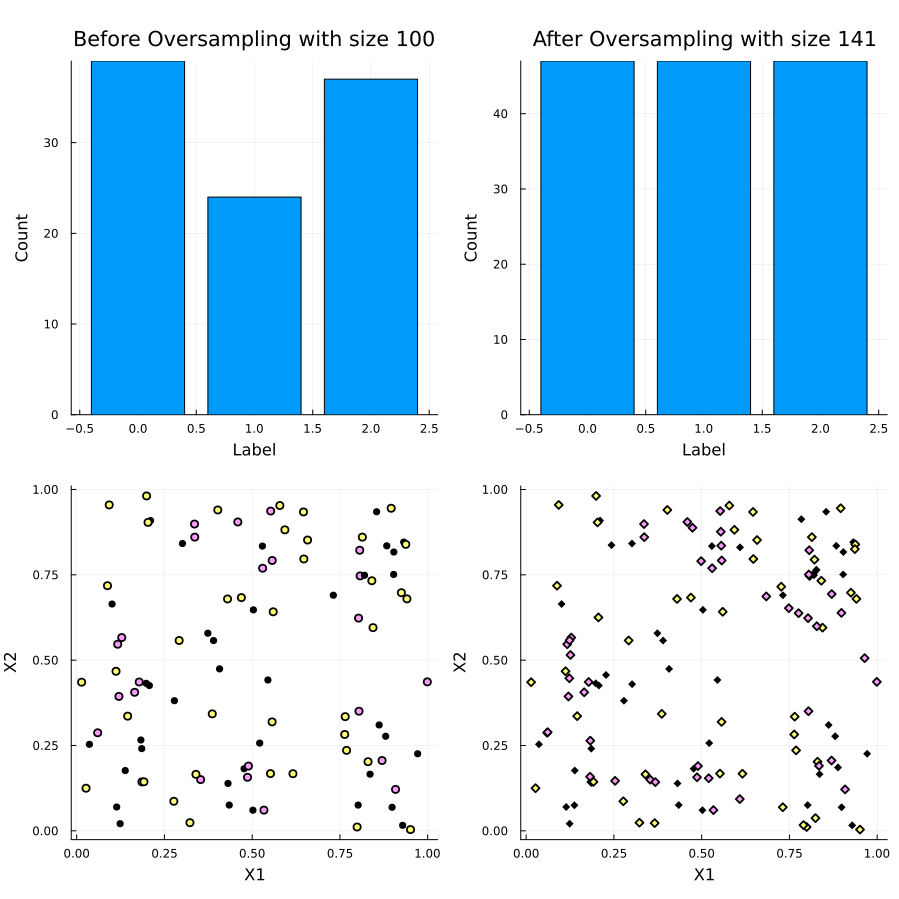

In [17]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)